In [1]:
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.image as mping
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import numpy as np
import random
import pandas as pd
from keras.models import load_model
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,Activation
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import SGD, Adam

X:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
X:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
X:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
X:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is 

In [ ]:
# https://cloud.tencent.com/developer/article/1741415
# https://zhuanlan.zhihu.com/p/69127267
# https://zhuanlan.zhihu.com/p/139267073
CASE_PATH="haarcascade_frontalface_default.xml"
DATASET_DIR=r'R:\PS\beauty\seeprettyface_race_yellow\unknow_zoom'

face_cascade=cv2.CascadeClassifier(CASE_PATH)
def save_faces(img,name,x,y,width,height):   
    image=img[y-10:y+height+10,x-10:x+width+10]
    cv2.imwrite(name,image)
    
sample_dir=r'R:\PS\beauty\seeprettyface_race_yellow\unknow'
all_labelname=[]
lfilenames = []
    #标签名列表
labelnames = []
    #遍历文件夹
count=0
for (dirpath,dirnames,filenames) in os.walk(sample_dir):
    for filename in filenames:
        try:       
            filename_path = os.path.join(dirpath,filename)
            image=cv2.imread(filename_path)
            gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
            faces=face_cascade.detectMultiScale(gray,
            scaleFactor=1.15,
            minNeighbors=4,
            minSize=(50,50)                        
           )
        
            if len (faces)>0:
                for face in faces:
                    x,y,w,h=face             
                    save_faces(image,'%s%d.png'%(DATASET_DIR,count),x,y,w,h)
#                     cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
                    count+=1
        except:
            print(filename_path)
            plt.imshow(image)
            #添加文件名
#             lfilenames.append(filename_path)
#             #添加文件名对应的标签
#             labelnames.append(dirpath.split('/')[-1])

In [2]:
def creat_dataset():
    sample_dir='R:/PS/beauty/zoom_in'
    all_labelname=[]
    lfilenames = []
        #标签名列表
    labelnames = []
        #遍历文件夹
    for (dirpath,dirnames,filenames) in os.walk(sample_dir):
        for filename in filenames:
                #每张图片的路径名
                filename_path = os.path.join(dirpath,filename)
                #添加文件名
                lfilenames.append(filename_path)
                #添加文件名对应的标签
                labelnames.append('WangQing')
    unknow_dir='R:/PS/beauty/seeprettyface_race_yellow/unknow'
    lfilenames2=[]
    labelnames2=[]            
    for (dirpath,dirnames,filenames) in os.walk(unknow_dir):
        for filename in filenames:
                #每张图片的路径名
                filename_path = os.path.join(dirpath,filename)
                #添加文件名
                lfilenames.append(filename_path)
                #添加文件名对应的标签
                labelnames2.append('stranger')
    all_labelname=labelnames+labelnames2    
    file_name=lfilenames+lfilenames2
    lab=[]
    labdict=[]
    labels=[]
    image_label_dict=[]
     #生成标签名列表
    lab = list(sorted(set(all_labelname)))
    #生成标签字典
    labdict = dict(zip(lab,list(range(len(lab)))))
    #生成与图片对应的标签列表
    labels = [labdict[i] for i in all_labelname]
    d={'path':file_name,'lable':labels}
    df = pd.DataFrame(data=d)
    data_df=df.sample(frac=1).reset_index(drop=True)
# data['path']
    return data_df

In [2]:
def resize_without_deformation(image,size=(200,200)):  
    height,width,_=image.shape
    longest_edge=max(height,width)
    top,bottom,left,right=0,0,0,0
    if height<longest_edge:
        height_diff=longest_edge-height
        top=int(height_diff/2)
        bottom=height_diff-top
    elif width<longest_edge:
        width_diff=longest_edge-width
        left=int(width_diff/2)
        right=width_diff-left
    image_with_border=cv2.copyMakeBorder(image,top,bottom,left,right,cv2.BORDER_CONSTANT,value = [0,0,0])
    resized_image=cv2.resize(image_with_border,size)
    return resized_image

In [51]:
def resize_image(df):
    size=None
    data_x=[]
    lable_y=[]
    for row in df['path'].values:
#         try:
        img_path=row
        im=cv2.imread(img_path)
        size=(200,200)
        resize_im=resize_without_deformation(im,size)
        img_gray=cv2.cvtColor(resize_im,cv2.COLOR_BGR2GRAY)
#         data_x.append(np.asarray(resize_im,dtype=np.int8))   
        data_x.append(img_gray/255.0) 
#         except IOError as e:       
#             print(e)
    lable_y=list(df['lable'])
       
    return data_x,lable_y

In [53]:
model = Sequential()

        # 以下代码将顺序添加CNN网络需要的各层，一个add就是一个网络层
model.add(Conv2D(32, (3, 3), input_shape=(200,200,1),activation='relu',padding="same")) 

model.add(MaxPooling2D(pool_size=(2, 2)))  # 5 池化层
model.add(Dropout(0.25))  # 6 Dropout层
model.add(Conv2D(64, (3, 3), activation='relu',padding="same"))  # 7  2维卷积层


model.add(MaxPooling2D(pool_size=(2, 2)))  # 11 池化层
model.add(Dropout(0.25))  # 12 Dropout层

model.add(Flatten())  # 13 Flatten层
model.add(Dense(512))  # 14 Dense层,又被称作全连接层
model.add(Activation('relu'))  # 15 激活函数层
model.add(Dropout(0.5))  # 16 Dropout层
model.add(Dense(2, activation='softmax'))  # 17 Dense层


model.summary()
sgd = SGD(lr=0.01, decay=1e-6,momentum=0.9, nesterov=True)  
        # 采用SGD+momentum的优化器进行训练，首先生成一个优化器对象
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])  

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 200, 200, 32)      320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 50, 50, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 160000)           

In [54]:
df=creat_dataset()
data_x,lable_y=resize_image(df)
data_x,lable_y=np.asarray(data_x,dtype=np.float32),np.asarray(lable_y,dtype=np.int32)
on_hot_lable=to_categorical(lable_y,2)

In [56]:
X_train, X_test, y_train, y_test= train_test_split(data_x,on_hot_lable,test_size=0.2,random_state=42)


In [64]:
X_train=X_train.reshape(-1,200, 200, 1)
X_test=X_test.reshape(-1,200, 200, 1)

In [62]:
X_test[0].shape

(200, 200)

In [65]:
X_train=np.array(X_train)
model.fit(X_train, y_train,
          batch_size=20,
          epochs=50,
          shuffle=True,
        validation_data=(X_test,y_test),
          verbose=0
          )

In [67]:
score =model.evaluate(X_test,y_test,verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
MODEL_PATH='WQ_face_model2.h5'
model.save(MODEL_PATH)

Test loss: 0.012902986025437713
Test accuracy: 1.0


In [3]:
CASE_PATH = "haarcascade_frontalface_default.xml"
face_cascade = cv2.CascadeClassifier(CASE_PATH)
face_recognition_model =Sequential()
MODEL_PATH = 'WQ_face_model2.h5'

In [4]:
face_recognition_model = load_model(MODEL_PATH)

In [74]:
image=cv2.imread('u3.jpg')
image_old = image.copy()
gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
faces=face_cascade.detectMultiScale(gray,
            scaleFactor=1.15,
            minNeighbors=4,
            minSize=(50,50)                        
           )
for face in faces:
    x,y,w,h=face  
size=(200,200)
resize_im=resize_without_deformation(image,size)
# resize_im=np.array(resize_im)
# gray=cv2.cvtColor(resize_im,cv2.COLOR_BGR2GRAY)
# gray=gray/255.0
resize_im=resize_im.reshape(-1,200,200,1)
# result=face_recognition_model.predict_classes(resize_im)
result=face_recognition_model.predict_classes(resize_im)

小寿星


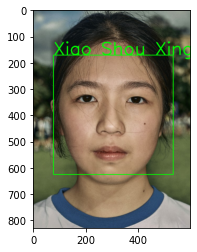

In [75]:
cv2.rectangle(image_old,(x,y),(x+w,y+h),(0,255,0),2)
font=cv2.FONT_HERSHEY_SIMPLEX
if result[0]==0:
    cv2.putText(image_old,'Xiao Shou Xing',(x,y-2),font,2.2,(0,255,0),3)
    print('小寿星')
else:
    cv2.putText(image_old,'Shei A Ni?'%result[0],(x,y-2),font,0.9,(0,255,0),3)
index=[2,1,0]
image=image_old[:,:,index]
plt.imshow(image)

# cv2.imshow('',image_old,(200,200))
# cv2.waitKey(0)
